In [1]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter


In [2]:
# read parquet file
df = dd.read_parquet("/home/duantu/Documents/UIC/Erdos_Institute/household_energy_consumption_forecasting/data/uk_30m.parquet")
# change to pandas dataframe
df = df.compute()
df_copy = df.copy(deep=True)

In [3]:
from datetime import date

# list of all date times 
# From 2012/10/12 to 2014/2/27, there are 503 days in total
time_stamp_list = df['datetime'].unique().tolist()

# Extract just the dates (without time)
dates = [ts.date() for ts in time_stamp_list]

# Count occurrences of each date
date_counts = Counter(dates)



# For some dates, time stamps are not cut at 30min marks sharply. For example, on 2013-11-22, some time
# stamps are marked at say, 22:24:09
# target_date = date(2013, 11, 22)
# len([t for t in time_stamp_list if t.date() == target_date])
# individual_household = df[df['id'] == 'uk_MAC001282']


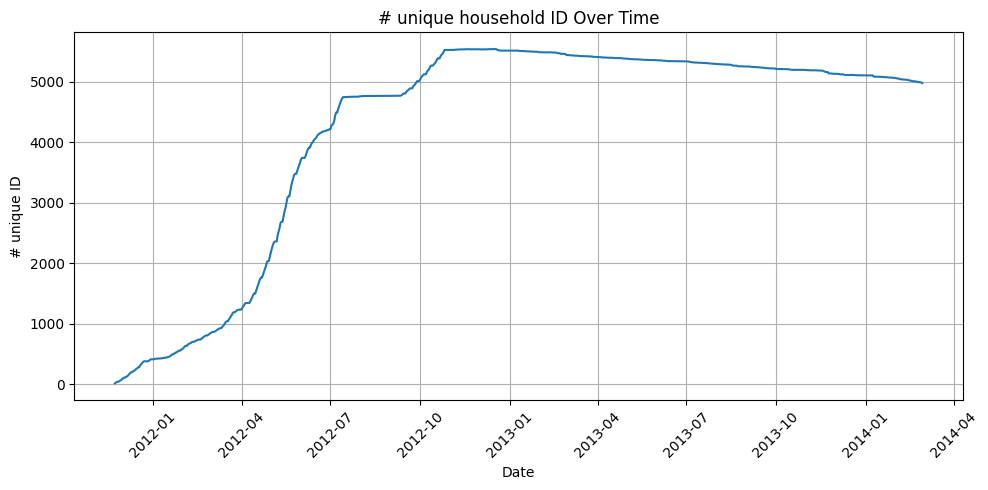

In [4]:
# All work below is done on df

# Almost all households have missing values, on the order of ~100

# not_nan_counts_by_household = df[df['target'].notna()]['id'].value_counts()

# 735 households have 2 years worth of notnan data
# 5375 households have 1 year worth of notnan data

# Figure out which time period to use so that we get the most number of households with complete data 

# For each date, print how many unique household id's it has. Pick a collection of dates with the most of such 
# Then, further reduce dates so that there is the least amount of missing target values 

count_unique_ids = df.groupby(df['datetime'].dt.date)['id'].nunique()
count_unique_ids.sort_values(ascending=False)

plt.figure(figsize=(10, 5))  # Width=10, Height=5
plt.plot(count_unique_ids.index, count_unique_ids.values)

# Labels and formatting
plt.title('# unique household ID Over Time')
plt.xlabel('Date')
plt.ylabel('# unique ID')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better fit
plt.tight_layout()
plt.show()



In [5]:
# Based on this graph, we first truncate data before 2012-10  
# Define date range (as datetime.date)
start_date = pd.to_datetime(df['datetime'].min()).date()

end_date = pd.to_datetime('2012-09-30').date()

# Filter out rows where the date is in the specified range
df = df[~df['datetime'].dt.date.between(start_date, end_date)]



In [13]:
# Now we investigate for which dates there are the most households with the least amount of missing target values
# For example, let's look at data for the target date
date_list = df['datetime'].dt.date.unique().tolist()
target_counts_list = [None] * len(date_list)


In [17]:
import time
i = 0
while i<len(date_list):
    date_i = date_list[i]
    # df_date_i = df[df['datetime'].dt.date == date_i]
    # target_counts_list[i] = df_date_i['id'].value_counts()
    # start_t = time.time()

    start = pd.to_datetime(date_i)
    end = start + pd.Timedelta(days=1)

    mask = (df['datetime'] >= start) & (df['datetime'] < end)
    target_counts = df.loc[mask, 'id'].value_counts()
    
    # count how many households have all 48 target values 
    target_counts_list[i] = sum(target_counts == 48)
    # end_t = time.time()
    # print(end_t-start_t)
    i = i+1 

In [28]:
type(date_list)

list

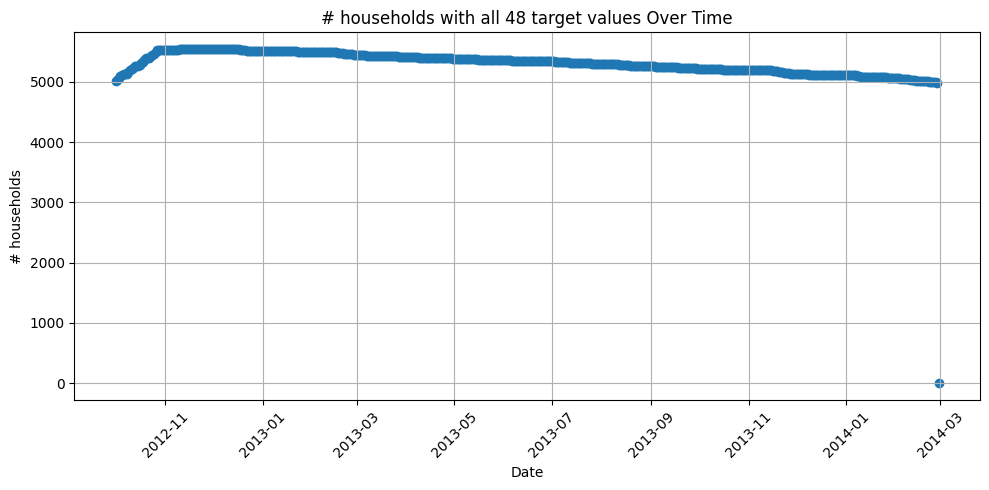

In [30]:
plt.figure(figsize=(10, 5))  # Width=10, Height=5
plt.scatter(date_list, target_counts_list)

# Labels and formatting
plt.title('# households with all 48 target values Over Time')
plt.xlabel('Date')
plt.ylabel('# households')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better fit
plt.tight_layout()
plt.show()

# From this plot, we see 2012-11 to 2013-11 is a good date range with almost all households having all 48 target values

In [31]:
# Filter df further to only keep data in the date range 2012-11 to 2013-11
start_date_further = pd.to_datetime('2012-11-1').date()
end_date_further = pd.to_datetime('2013-11-30').date()
df = df[df['datetime'].dt.date.between(start_date_further,end_date_further)]


In [32]:
# since not all of recorded times are at 30 min marks exactly, we first make sure that they are roughly following the 30 min increments 
# for each household id, check if its data has increasing times. 



# Ensure datetime is parsed and extract components
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date
df['time_seconds'] = (
    df['datetime'].dt.hour * 3600 +
    df['datetime'].dt.minute * 60 +
    df['datetime'].dt.second
)


In [ ]:

############ this cell takes a long time to run, don't need to be re-run #############


# # Check if all target values are listed monotonically increasing 
# from tqdm import tqdm  # optional, for progress bar

# # Define monotonicity check
# def is_monotonic_group(x):
#     return (x.diff().dropna() < 0).any() == False

# monotonic_results = []

# # Loop over each id to reduce memory usage
# for uid in tqdm(df['id'].unique()):
#     subdf = df[df['id'] == uid].copy()
#     subdf.sort_values(['date', 'time_seconds'], inplace=True)
#     flags = subdf.groupby('date')['time_seconds'].agg(is_monotonic_group)
#     for date, flag in flags.items():
#         monotonic_results.append((uid, date, flag))

# # Build result DataFrame
# monotonic_flags = pd.DataFrame(monotonic_results, columns=['id', 'date', 'is_monotonic'])
# # check if there are any households for which the time data is not monotonically increasing, and the answer is NO, as we wanted.
# sum(monotonic_flags['is_monotonic']!= True)

In [33]:
# drop the "category" column

df = df.drop(columns='category')

# Step 1: Get the full set of dates in your data
all_dates = df['date'].unique()
num_dates = len(all_dates)
# For each id, check how many unique dates they have
id_date_counts = df.groupby('id')['date'].nunique()

# Step 2: Count number of 48-value days for each id
group_counts = df.groupby(['id', 'date'])['target'].count()

# Step 3: Identify which (id, date) groups are incomplete
incomplete_groups = group_counts[group_counts != 48]

# Step 4: Get all bad IDs — any ID with any incomplete date
bad_ids = incomplete_groups.index.get_level_values('id').unique()

df = df[~df['id'].isin(bad_ids)]

# # group df by id and date
# group_counts = df.groupby(['id', 'date'], sort=False, observed=True).size()

# # Filter out households that don't have exactly 48 values for every day in our date range
# incomplete = group_counts[group_counts != 48]

# # remove these households from df
# bad_ids = incomplete.index.get_level_values('id').unique()

# # Step 2: Remove all rows with those 'id' values
# df = df[~df['id'].isin(bad_ids)]

In [34]:
counts_final = df.groupby(['date', 'id'])['target'].count()

# Step 3: Find which groups do NOT have exactly 48 values
incomplete_final_check = counts_final[counts_final != 48]

# Step 4: View the result
print(incomplete_final_check)

Series([], Name: target, dtype: int64)


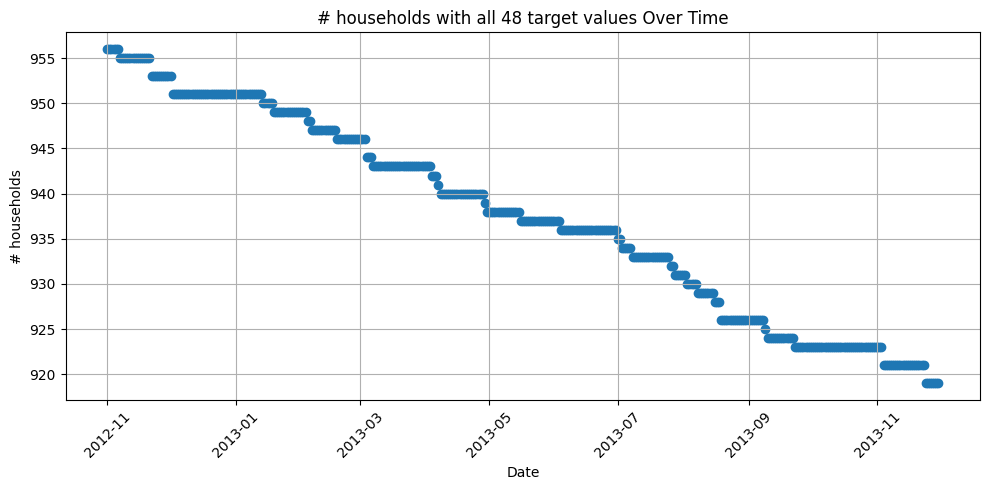

In [43]:
plt.figure(figsize=(10, 5))  # Width=10, Height=5
plt.scatter(df['date'].unique(), df.groupby('date')['id'].nunique())

# Labels and formatting
plt.title('# households with all 48 target values Over Time')
plt.xlabel('Date')
plt.ylabel('# households')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better fit
plt.tight_layout()
plt.show()



In [ ]:
# Now, all households in df have exactly 48 target values for the days that they have data on
# i want to further clean df so that for every day, every houeshold has 48 target values

# Step 2: Group by ['id', 'date'] and count non-null 'target' values
grouped = df.groupby(['id', 'date'], sort=False)['target'].count()

# Step 3: Use boolean mask to find where count == 48
mask = grouped == 48

# Step 4: Reshape to (id, date) pivot and sum across rows
# Only ids where all dates are valid (48 values per date)
valid_counts = mask.groupby('id').sum()

# Step 5: Select ids with correct number of complete days
good_ids = valid_counts[valid_counts == num_dates].index

# Step 6: Filter original df
df_clean = df[df['id'].isin(good_ids)]

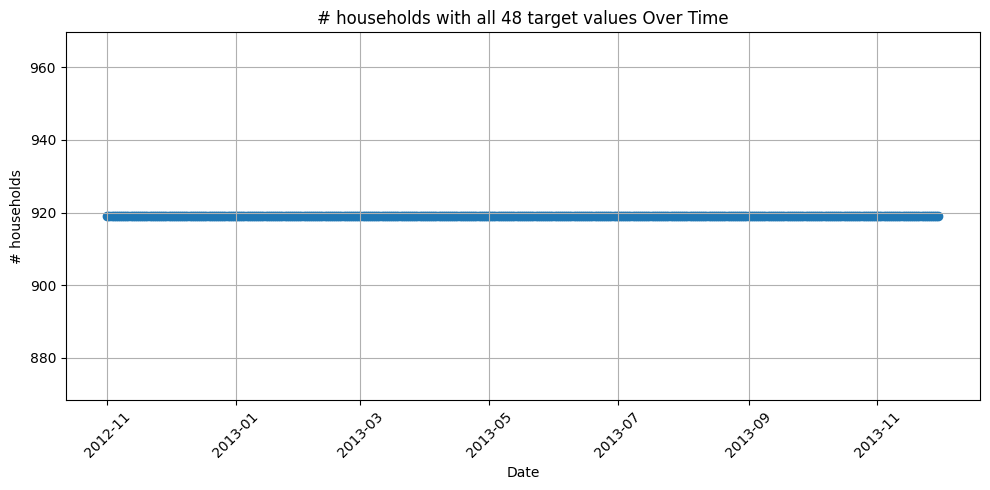

In [ ]:
# The following plot verifies that in df_clean, indeed every household has exactly 48 target values for all dates in the range.

plt.figure(figsize=(10, 5))  # Width=10, Height=5
plt.scatter(df['date'].unique(), df_clean.groupby('date')['id'].nunique())

# Labels and formatting
plt.title('# households with all 48 target values Over Time')
plt.xlabel('Date')
plt.ylabel('# households')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better fit
plt.tight_layout()
plt.show()


In [49]:
# save df_clean as a csv file
df_clean.to_csv("uk_data_clean.csv", index=False) # Export to CSV